# Frechet Gesture Distance From Image Data Representation and Resnet-based AutoEncoder 

## Optional: Style selection

In [ ]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
# uncomment and execute line to try a new theme
#set_nb_theme('onedork')
#set_nb_theme('chesterish')
#set_nb_theme('grade3')
#set_nb_theme('oceans16')
#set_nb_theme('solarizedl')
#set_nb_theme('solarizedd')
set_nb_theme('monokai')

## Import
##### might not need all the import below 

In [ ]:
import random
import numpy as np 
import math

import sys 
import csv 
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt 
from scipy import linalg
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from skimage.util import random_noise

[sys.path.append(i) for i in ['.', '..']]
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx
from torch.utils.data import Dataset, DataLoader
from torch_snippets import *
#from data_loader.lmdb_data_loader import *

from fastai.data.all import *
from fastai.vision.all import *

## Config parameters

In [ ]:
class Args:
    
    def __init__(self):
        self.name = 'gesture_autoencoder'

        self.train_data_path = 'data/ted_dataset/lmdb_train'
        self.val_data_path =  'data/ted_dataset/lmdb_val'
        self.test_data_path =  'data/ted_dataset/lmdb_test'

        self.model_save_path = 'output/train_h36m_gesture_autoencoder'
        self.random_seed =  -1

        # model params
        self.model = 'gesture_autoencoder'
        self.mean_dir_vec= [ 0.0154009, -0.9690125, -0.0884354, -0.0022264, -0.8655276, 0.4342174, -0.0035145, -0.8755367, -0.4121039, -0.9236511, 0.3061306, -0.0012415, -0.5155854,  0.8129665,  0.0871897, 0.2348464,  0.1846561,  0.8091402,  0.9271948,  0.2960011, -0.013189 ,  0.5233978,  0.8092403,  0.0725451, -0.2037076, 0.1924306,  0.8196916]
        self.mean_pose= [ 0.0000306,  0.0004946, 0.0008437,  0.0033759, -0.2051629, -0.0143453,  0.0031566, -0.3054764,  0.0411491,  0.0029072, -0.4254303, -0.001311 , -0.1458413, -0.1505532, -0.0138192, -0.2835603,  0.0670333,  0.0107002, -0.2280813,  0.112117 , 0.2087789,  0.1523502, -0.1521499, -0.0161503,  0.291909 , 0.0644232,  0.0040145,  0.2452035,  0.1115339,  0.2051307]

        # train params
        self.epochs= 500
        self.batch_size= 128
        self.learning_rate= 0.0005

        # dataset params
        self.motion_resampling_framerate= 15
        self.n_poses= 34
        self.n_pre_poses= 4
        self.subdivision_stride= 10
        self.loader_workers= 4
        
args = Args()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

## Utils function
#### From the author, do not edit!

In [ ]:
dir_vec_pairs = [(0, 1, 0.26), (1, 2, 0.18), (2, 3, 0.14), (1, 4, 0.22), (4, 5, 0.36),
                 (5, 6, 0.33), (1, 7, 0.22), (7, 8, 0.36), (8, 9, 0.33)]  # adjacency and bone length

def convert_dir_vec_to_pose(vec):
    vec = np.array(vec)

    if vec.shape[-1] != 3:
        vec = vec.reshape(vec.shape[:-1] + (-1, 3))

    if len(vec.shape) == 2:
        joint_pos = np.zeros((10, 3))
        for j, pair in enumerate(dir_vec_pairs):
            joint_pos[pair[1]] = joint_pos[pair[0]] + pair[2] * vec[j]
    elif len(vec.shape) == 3:
        joint_pos = np.zeros((vec.shape[0], 10, 3))
        for j, pair in enumerate(dir_vec_pairs):
            joint_pos[:, pair[1]] = joint_pos[:, pair[0]] + pair[2] * vec[:, j]
    elif len(vec.shape) == 4:  # (batch, seq, 9, 3)
        joint_pos = np.zeros((vec.shape[0], vec.shape[1], 10, 3))
        for j, pair in enumerate(dir_vec_pairs):
            joint_pos[:, :, pair[1]] = joint_pos[:, :, pair[0]] + pair[2] * vec[:, :, j]
    else:
        assert False

    return joint_pos


def convert_pose_seq_to_dir_vec(pose):
    if pose.shape[-1] != 3:
        pose = pose.reshape(pose.shape[:-1] + (-1, 3))

    if len(pose.shape) == 3:
        dir_vec = np.zeros((pose.shape[0], len(dir_vec_pairs), 3))
        for i, pair in enumerate(dir_vec_pairs):
            dir_vec[:, i] = pose[:, pair[1]] - pose[:, pair[0]]
            dir_vec[:, i, :] = normalize(dir_vec[:, i, :], axis=1)  # to unit length
    elif len(pose.shape) == 4:  # (batch, seq, ...)
        dir_vec = np.zeros((pose.shape[0], pose.shape[1], len(dir_vec_pairs), 3))
        for i, pair in enumerate(dir_vec_pairs):
            dir_vec[:, :, i] = pose[:, :, pair[1]] - pose[:, :, pair[0]]
        for j in range(dir_vec.shape[0]):  # batch
            for i in range(len(dir_vec_pairs)):
                dir_vec[j, :, i, :] = normalize(dir_vec[j, :, i, :], axis=1)  # to unit length
    else:
        assert False

    return dir_vec

## Pytorch Dataset with noisy function and image transform as static methods 

In [ ]:
train_subject = ['S1', 'S5', 'S6', 'S7', 'S8', 'S9']
test_subject = ['S11']

class Human36M(Dataset):
    def __init__(self, path, mean_data, is_train=True, augment=False, method=None, std=0, to_image=None):
        n_poses = 34
        
        '''
        H36M_NAMES = ['']*32
        H36M_NAMES[0]  = 'Hip'
        H36M_NAMES[1]  = 'RHip'
        H36M_NAMES[2]  = 'RKnee'
        H36M_NAMES[3]  = 'RFoot'
        H36M_NAMES[4]  = 'RFootTip'
        H36M_NAMES[6]  = 'LHip'
        H36M_NAMES[7]  = 'LKnee'
        H36M_NAMES[8]  = 'LFoot'
        H36M_NAMES[12] = 'Spine'
        H36M_NAMES[13] = 'Thorax'
        H36M_NAMES[14] = 'Neck/Nose'
        H36M_NAMES[15] = 'Head'
        H36M_NAMES[17] = 'LShoulder'
        H36M_NAMES[18] = 'LElbow'
        H36M_NAMES[19] = 'LWrist'
        H36M_NAMES[25] = 'RShoulder'
        H36M_NAMES[26] = 'RElbow'
        H36M_NAMES[27] = 'RWrist'
        '''

        target_joints = [1, 6, 12, 13, 14, 15, 17, 18, 19, 25, 26, 27]  # see https://github.com/kenkra/3d-pose-baseline-vmd/wiki/body

        self.method = method
        self.std = std
        self.is_train = is_train
        self.augment = augment
        self.mean_data = mean_data
        self.data = []

        if is_train:
            subjects = train_subject
        else:
            subjects = test_subject

        # loading data and normalize
        frame_stride = 2
        data = np.load(path, allow_pickle=True)['positions_3d'].item()
        for subject, actions in data.items():
            if subject not in subjects:
                continue

            for action_name, positions in actions.items():
                print('positions : ', positions.shape)
                assert False
                positions = positions[:, target_joints]
                positions = self.normalize(positions)
                for f in range(0, len(positions), 10):
                    if f+n_poses*frame_stride > len(positions):
                        break
                    gesture = positions[f:f+n_poses*frame_stride:frame_stride]
                    self.data.append(gesture)

    def __getitem__(self, index):
        poses = self.data[index]
        dir_vec = convert_pose_seq_to_dir_vec(poses)
        poses = convert_dir_vec_to_pose(dir_vec)
        
        '''Noise for data augmentation'''
        if self.augment:  # data augmentation by adding gaussian noises on joints coordinates            
            rand_val = random.random()
            if rand_val < 0.2:
                poses = poses.copy()
                poses += np.random.normal(0, 0.002 ** 0.5, poses.shape)
            else:
                poses = poses.copy()
                poses += np.random.normal(0, 0.0001 ** 0.5, poses.shape)
            
        '''Noise for data alteration for FGD sensitivity assessment'''    
        if self.method is not None: #poses alteration by adding noises of different types
            if hasattr(self, self.method):
                noise_function = getattr(self, self.method)
                if len(noise_function(poses, self.std)) == 2: #temporal noise
                    noise, r = noise_function(poses, self.std)
                    poses[r:r+self.std] = poses[r:r+self.std] + noise
                else:
                    poses += noise_function(poses, self.std)
            else:
                raise NotImplementedError
        
        dir_vec = convert_pose_seq_to_dir_vec(poses)
        dir_vec = dir_vec.reshape(dir_vec.shape[0], -1)
        dir_vec = dir_vec - self.mean_data 

        poses = torch.from_numpy(poses).float()
        dir_vec = torch.from_numpy(dir_vec).float()
        return poses, dir_vec

    def __len__(self):
        return len(self.data)

    def normalize(self, data):

        # pose normalization
        for f in range(data.shape[0]):
            data[f, :] -= data[f, 2]
            data[f, :, (0, 1, 2)] = data[f, :, (0, 2, 1)]  # xy exchange
            data[f, :, 1] = -data[f, :, 1]  # invert y

        # frontalize based on hip joints
        for f in range(data.shape[0]):
            hip_vec = data[f, 1] - data[f, 0]
            angle = np.pi - np.math.atan2(hip_vec[2], hip_vec[0])  # angles on XZ plane
            if 180 > np.rad2deg(angle) > 0:
                pass
            elif 180 < np.rad2deg(angle) < 360:
                angle = angle - np.deg2rad(360)

            rot = self.rotation_matrix([0, 1, 0], angle)
            data[f] = np.matmul(data[f], rot)

        data = data[:, 2:]  # exclude hip joints
        return data

    @staticmethod
    def to_image(data, name):
        assert len(data.shape) == 3, "data has no valid shape to plot"
        plt.figure()
        #plt.imshow(data.numpy())
        plt.imsave(name+'.png', data.numpy())
        
    @staticmethod
    def rotation_matrix(axis, theta):
        """
        Return the rotation matrix associated with counterclockwise rotation about
        the given axis by theta radians.
        """
        axis = np.asarray(axis)
        axis = axis / math.sqrt(np.dot(axis, axis))
        a = math.cos(theta / 2.0)
        b, c, d = -axis * math.sin(theta / 2.0)
        aa, bb, cc, dd = a * a, b * b, c * c, d * d
        bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
        return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                         [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                         [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    @staticmethod
    def salt_and_pepper(data, std):
        u = np.random.uniform(size=data[0].shape) #Applying the same noise on every frame to avoid discontinuities
        noise = np.zeros(u.shape)
        cond0 = np.where(u<=std/2)
        cond1 = np.where((u>std/2) & (u<=std))
        noise[cond0[0], cond0[1], cond0[2]] = 0.2
        noise[cond1[0], cond1[1], cond1[2]] = -0.2
        return noise
    
    @staticmethod
    def gaussian_noise(data, std):
        return np.random.normal(0, std, data[0].shape) #Applying the same noise on every frame to avoid discontinuities

    @staticmethod
    def temporal_noise(data, std):
        r = np.random.randint(1, data.shape[0] - std - 1)
        noise = np.random.normal(0, 0.003 ** 0.5, data[0].shape)
        return noise, r



In [ ]:
class Normalization:
    
    def get_normalized_all(data):
        #compute min and max on the dataset on all joints
        assert data.shape[-1] == 3, "Last channel is not xyz"
        bound={}
        bound['max'] = torch.tensor((data[..., 0].max(), data[..., 1].max(), data[..., 2].max())) 
        bound['min'] = torch.tensor((data[..., 0].min(), data[..., 1].min(), data[..., 2].min()))

        return (data - bound['min']) / (bound['max'] - bound['min'])
    
    def get_normalized_joint(data):
        assert data.shape[-1] == 3, "Last channel is not xyz"
        data_n = torch.empty(data.shape)
        bound = {}
        
        for i in range(data.shape[-2]):#n joints
            bound[f'max_{i}'] = torch.tensor((data[..., i, 0].max(), data[..., i, 1].max(), data[..., i, 2].max()))
            bound[f'min_{i}'] = torch.tensor((data[..., i, 0].min(), data[..., i, 1].min(), data[..., i, 2].min()))
            
            for o in range(data.shape[-1]):
                data_n[...,i,o] = (data[...,i,o] - bound[f'min_{i}'][o]) / (bound[f'max_{i}'][o] - bound[f'min_{i}'][o])
            
        return data_n

## Prepare datasets

In [ ]:
path  = '../Gesture-Generation-from-Trimodal-Context/data/h36m/data_3d_h36m.npz'
mean_dir_vec = np.squeeze(np.array(args.mean_dir_vec))

train_dataset = Human36M(path, mean_dir_vec, is_train=True, augment=False)
val_dataset = Human36M(path, mean_dir_vec, is_train=False, augment=False)
#val_dataset_noisy = Human36M(path, mean_dir_vec, is_train=False, augment=False, method=method, std=std)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=False, drop_last=True)

to_image() test code : show or save an image computed from gesture

In [ ]:
_, target_vec = next(iter(test_loader))
target_vec_ = Normalization.get_normalized_all(target_vec[0].reshape(args.n_poses, len(args.mean_dir_vec) // 3, -1)) #eliminate batch size and create 3 channels for xyz
Human36M.to_image(torch.swapaxes(target_vec_, 0,1), 'all')
target_vec_ = Normalization.get_normalized_joint(target_vec[0].reshape(args.n_poses, len(args.mean_dir_vec) // 3, -1)) #eliminate batch size and create 3 channels for xyz
Human36M.to_image(torch.swapaxes(target_vec_, 0,1), 'joints')

## Concatenate directory vectors
##### Useful to create the image dataset

In [ ]:
latent_spaces = None
dataset = train_loader
target_poses, target_vecs = None, None
save = False

for idx, (target_pose, target_vec) in enumerate(dataset,0):
    #Concatenation
    if target_poses is None and target_vecs is None:
        target_poses, target_vecs = target_pose, target_vec
    else:
        target_poses, target_vecs = torch.cat((target_poses, target_pose), 0), torch.cat((target_vecs, target_vec), 0)
    if save:
        np.savez('test_gestures_gt', data = target_poses)

target_vecs = target_vecs.reshape(len(target_vecs), args.n_poses, len(args.mean_dir_vec) // 3, -1)
print(target_vecs.shape)

## Transform the directory vectors to images
#### MinMax normalization to build image
###### Normalization parameters computed by joint (1 min 1 max by joint) or for all of them (1 min 1 max for all) 

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

save_db = True
if dataset == train_loader:
    print('train!')
    ds = 'train'
elif dataset == test_loader:
    print('valid!')
    ds = 'valid'
    
if save_db: #Create the dataset folder and files of training and validation images. Take time to run... 
    
    root = '../Gesture-Generation-from-Trimodal-Context/data/gest2im'
    #root = os.path.join(root, ds)
    t_all = Normalization.get_normalized_all(target_vecs)
    t_joint = Normalization.get_normalized_joint(target_vecs)

    paths = ['all', 'joint']
    for path in paths:
        if not os.path.exists(os.path.join(root, path, ds)):
            os.makedirs(os.path.join(root, path, ds))

    for i in tqdm(range(len(target_vecs))):
        Human36M.to_image(torch.swapaxes(t_all[i], 0,1), os.path.join(root, paths[0], ds, f'{i}'))
        Human36M.to_image(torch.swapaxes(t_joint[i], 0,1), os.path.join(root, paths[1], ds, f'{i}'))

In [ ]:
root = '../Gesture-Generation-from-Trimodal-Context/data/gest2im'
paths = ['all', 'joint']
ds = 'train'
os.path.join(root, paths[0], ds)
len(target_vecs)
len(t_all)

## Building NN Modules

In [ ]:
class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = nn.Conv2d(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    
    def forward(self,x):
        return self.conv(
            nn.functional.interpolate(
                x,size=self.out_shape,scale_factor=self.scale,mode='bilinear',align_corners=True))
    
def get_upSamp(feat_in,feat_out, out_shape=None, scale=2, act='relu'):
    
    upSamp = UpSample(feat_in,feat_out,out_shape=out_shape,scale=scale).cuda()
    
    layer = nn.Sequential(upSamp)
    
    if act == 'relu':
        act_f = nn.ReLU(inplace=True).cuda()
        bn = nn.BatchNorm2d(feat_out).cuda()
        layer.add_module('ReLU',act_f)
        layer.add_module('BN',bn)
    elif act == 'sig':
        act_f = nn.Sigmoid()
        layer.add_module('Sigmoid',act_f)
    return layer

def add_layer(m,feat_in,feat_out,name,out_shape=None,scale=2,act='relu'):
    upSamp = get_upSamp(feat_in,feat_out,out_shape=out_shape,scale=scale,act=act)
    m.add_module(name,upSamp)
    
def save_onnx(path, name, model):
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    torch.onnx.export(model, 
                     torch.rand((64,3,28,28)).to(device), 
                     os.path.join(path, name), 
                     opset_version=11, 
                     do_constant_folding=True,
                     input_names = ['input'], 
                     output_names = ['output'])

## Fastai solution to build dataloaders

In [ ]:
splitter = FuncSplitter(lambda o: Path(o).parent.name == 'valid')
root = Path('../Gesture-Generation-from-Trimodal-Context/data/gest2im/all')

dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                  get_items=get_image_files,
                  get_y=lambda x: x,
                  splitter = splitter,
                  item_tfms=[Resize(28)])

dls = dblock.dataloaders(root, batch_size = args.batch_size, num_workers=0)


x_ = dls.one_batch()
(x_[0] == x_[1]).all()

## Building the resnet34 Autoencoder 

In [ ]:
model = resnet34(pretrained=True).to(device)
ae= nn.Sequential(*list(model.children())[:-3])
conv = nn.Conv2d(256, 32, kernel_size =(2,2)).to(device)
ae.add_module('CodeIn', conv)

## Change size by 28x28 if resized 
#print(ae(torch.rand((64,3,9,34)).to(device)).size())
add_layer(ae, 32, 256, 'CodeOut') #out: (2,2) 
#print(ae(torch.rand((64,3,9,34)).to(device)).size())
add_layer(ae, 256, 128, 'Upsample0')#out: (4,4)
#print(ae(torch.rand((64,3,9,34)).to(device)).size())
add_layer(ae, 128, 64, 'Upsample1', out_shape=(7,7), scale=None) #out: (7,7)
#print(ae(torch.rand((64,3,9,34)).to(device)).size())
add_layer(ae, 64, 32, 'Upsample2') #out: out_shape
#print(ae(torch.rand((64,3,9,34)).to(device)).size())
add_layer(ae, 32, 3, 'Upsample3', act='sig') #out: out_shape
#ae(torch.rand((64,3,9,34)).to(device)).size()

## Save model graph to onnx to visualize architecture with netron (e.g.)

In [ ]:
#Export onnx to check model
import torch.onnx

path = os.path.join('..', 'Gesture-Generation-from-Trimodal-Context', 'scripts', 'model', 'onnx')
if not os.path.exists(path):
    os.makedirs(path)
    
save_onnx(path, 'resnet34.onnx', model)
save_onnx(path, 'resnet34_AE.onnx', ae)

## AE Training

In [ ]:
variational_encoding = False
if not variational_encoding:
    loss_func = F.l1_loss
    
learn = Learner(dls, ae, loss_func = loss_func, metrics=[mae])

In [ ]:
suggested_lr = learn.lr_find(stop_div=False,num_it=200)
print('lr = ', suggested_lr)

In [ ]:
print('Validation loss before fit', learn.validate()[0])

cbs = []
cbs.append(SaveModelCallback())
cbs.append(CSVLogger(fname='models/log.csv', append=True)) 
learn.fit_one_cycle(10,lr_max=suggested_lr, cbs=cbs)

In [ ]:
learn.show_results()

In [ ]:
suggested_lr

## Build noisy dataloaders and save it into related folders

In [ ]:
ALL_NOISE = ['gaussian_noise', 'saltandpepper_noise', 'temporal_noise']
method = 'saltandpepper_noise'
method_str = method.split('_')[0]
save = False

if method not in ALL_NOISE:
    raise NotImplementedError
    
if method == 'gaussian_noise':
    stds = [0.0316, 0.0447, 0.0548]
elif method == 'saltandpepper_noise':
    stds = [0.1,0.15,0.2] #This is not noise std!
elif method == 'temporal_noise':
    stds = [1,5,10] #This is not noise std!
    
method='gaussian_noise'
method_str = method.split('_')[0]
std = 0.0548


In [ ]:
from tqdm import tqdm

path  = '../Gesture-Generation-from-Trimodal-Context/data/h36m/data_3d_h36m.npz'
mean_dir_vec = np.squeeze(np.array(args.mean_dir_vec))

val_dataset_noisy = Human36M(path, mean_dir_vec, is_train=False, augment=False, method=method,std=std)
test_loader_noisy = DataLoader(dataset=val_dataset_noisy, batch_size=args.batch_size, shuffle=False, drop_last=True)

dataset = test_loader_noisy
target_poses, target_vecs = None, None
save = False
save_db = True

if dataset == train_loader:
    print('train!')
    ds = 'train'
elif dataset == test_loader:
    print('valid!')
    ds = 'valid'
elif dataset == test_loader_noisy:
    print('valid!')
    ds = 'valid'

for idx, (target_pose, target_vec) in enumerate(dataset,0):
    #Concatenation
    if target_poses is None and target_vecs is None:
        target_poses, target_vecs = target_pose, target_vec
    else:
        target_poses, target_vecs = torch.cat((target_poses, target_pose), 0), torch.cat((target_vecs, target_vec), 0)
if save:
    np.savez('test_gestures_gt', data = target_poses)

target_vecs_noisy = target_vecs.reshape(len(target_vecs), args.n_poses, len(args.mean_dir_vec) // 3, -1)

if save_db: #Create the dataset folder and files of training and validation images. Take time to run... 
    
    root = '../Gesture-Generation-from-Trimodal-Context/data/gest2im'
    #root = os.path.join(root, ds)
    t_all = Normalization.get_normalized_all(target_vecs_noisy)
    t_joint = Normalization.get_normalized_joint(target_vecs_noisy)

    paths = [f'all_{method_str}_{std}', f'joint_{method_str}_{std}']
    for path in paths:
        if not os.path.exists(os.path.join(root, path, ds)):
            os.makedirs(os.path.join(root, path, ds))

    for i in tqdm(range(len(target_vecs))):
        Human36M.to_image(torch.swapaxes(t_all[i], 0,1), os.path.join(root, paths[0], ds, f'{i}'))
        Human36M.to_image(torch.swapaxes(t_joint[i], 0,1), os.path.join(root, paths[1], ds, f'{i}'))

## Plotting the results evaluate by Conv2d.py

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

method_str = 'gaussian'
n_poses = 64

if n_poses == 34:
    if method_str == 'gaussian':
        zeta = np.array([0.001,0.002,0.003,0.01,0.1])
        mean = np.array([0.08240203,0.22613631,0.39619036,1.67765289,6.87118926])
        std = np.array([0.00132868, 0.00347157, 0.00530228, 0.01495325, 0.03741726])
    elif method_str == 'saltandpepper':
        zeta = np.array([0.1,0.15,0.2,0.5, 0.75])
        mean = np.array([0.4685614,0.81640321,1.18324545,3.17272931,4.26709501])
        std = np.array([0.0089291, 0.01159924, 0.01342414, 0.02509215, 0.03474339])
    elif method_str == 'temporal':
        zeta = np.array([1,5,10,20])
        mean = np.array([0.0053349,0.02376117,0.06705022,0.18552624])
        std = np.array([0.00010305, 0.00040202, 0.00105999, 0.00263833])
        
elif n_poses == 18:
    if method_str == 'gaussian':
        zeta = np.array([0.001,0.002,0.003,0.01,0.1])
        mean = np.array([0.07783876,0.19267581,0.322209097,1.39058165,5.90966723])
        std = np.array([0.0148825, 0.02148662, 0.02356199, 0.017614, 0.03530067])
    elif method_str == 'saltandpepper':
        zeta = np.array([0.1,0.15,0.2,0.5, 0.75])
        mean = np.array([0.36634205,0.6579607,0.9713845,2.69054704,3.65799937])
        std = np.array([0.00910893, 0.01183706, 0.01588302, 0.02437597, 0.0286117])
    elif method_str == 'temporal':
        zeta = np.array([1,5,10,15])
        mean = np.array([0.03455983,0.09343792,0.16167952,0.28593734])
        std = np.array([0.00292365, 0.00479823, 0.00764541, 0.00876047])
        
elif n_poses == 64:
    if method_str == 'gaussian':
        zeta = np.array([0.001,0.002,0.003,0.01,0.1])
        mean = np.array([0.06762687,0.15387838,0.24231669,1.09294023,5.176])
        std = np.array([0.0312, 0.0416557, 0.0283022, 0.02501722, 0.03613215])
    elif method_str == 'saltandpepper':
        zeta = np.array([0.1,0.15,0.2,0.5, 0.75])
        mean = np.array([0.36149179,0.58324156,0.81554461 ,2.20881879,3.0648695])
        std = np.array([0.07254474, 0.06982494, 0.0617641, 0.02089, 0.02318809])
    elif method_str == 'temporal':
        zeta = np.array([1,5,10,15, 32])
        mean = np.array([0.00155409,0.00613046,0.01181387,0.02123891, 0.07215359])
        std = np.array([0.000102, 0.00015345, 0.00026414, 0.00041197, 0.00390443])
    
save = False

fig, ax = plt.subplots()
ax.set_ylabel('Fréchet Gesture Distance')
x = np.arange(len(mean))
ax.set_xticks(x)
ax.set_xticklabels(zeta)
ax.set_title(f'Fréchet Gesture Distance evolution with $\zeta$ ({method_str} noise)')
ax.bar(x, mean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.yaxis.grid(True)

plt.tight_layout()
if save:
    plt.savefig(f'../Gesture-Generation-from-Trimodal-Context/figures/{args.n_poses} frames/fgd_{method_str}_{n}_s2_onenoise.png')
else:
    plt.show()

(5,)
(5,)
(5,)


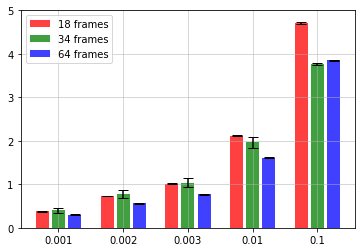

In [24]:
import os
import matplotlib.pyplot as plt 
import numpy as np

mode = 'motion' #'motion' or ' ' (gesture)

noise = 'gaussian_noise'
method = f'{noise}_motion' if mode == 'motion' else noise

#noises = ['gaussian_noise', 'saltandpepper_noise', 'temporal_noise']
#methods = ['gaussian_noise_motion', 'saltandpepper_motion', 'temporal_noise_motion']

if 'gaussian_noise' in method:
   zeta = np.array([0.001,0.002,0.003,0.01,0.1])
elif 'saltandpepper_noise' in method:
   zeta = np.array([0.1,0.15,0.2,0.5, 0.75])
elif 'temporal_noise' in method:
   zeta = np.array([1,5,10,15,32])

xindex = np.array([0,1,2,4,5,6,8,9,10,12,13,14,16,17,18])
colors = ['red', 'green', 'blue']
labels = ['18 frames' , '34 frames', '64 frames']
#fig, axes = plt.subplots(3, sharex=True, sharey=True)
fig, ax = plt.subplots()
ax.set_ylim([0, 5])

#for idx,ax in enumerate(axes):
files = [x for x in os.listdir('./evaluation/') if method in x]
means, stds = np.zeros((len(files), len(zeta))), np.zeros((len(files),  len(zeta)))
for i,f in enumerate(files):
    data = np.load('./evaluation/' + f)
    print(data['mean'].shape)
    if len(data['mean'])!=len(zeta):
        mean_ = np.concatenate((data['mean'], np.array([0])))
        std_ = np.concatenate((data['std'], np.array([0])))
    else:
        mean_ = data['mean']
        std_ = data['std']
    means[i], stds[i] = mean_, std_

#ax.set_ylabel(f'Fréchet {mode} Distance')
for f in range(means.shape[-1]):
   imin = f*3
   imax = imin + 3
   if f < means.shape[-1]-1:
       ax.bar(xindex[imin:imax], means[:,f], color = colors, yerr=stds[:,f], align='center', alpha=0.75, ecolor='black', capsize=5)#, label='a')
else:
    for j in range(len(colors)):
        ax.bar(xindex[imin:imax][j], means[j,f], color = colors[j], yerr=stds[j,f], align='center', alpha=0.75, ecolor='black', capsize=5, label=labels[j])
    xt = np.arange(1, 20, 4)
ax.set_xticks(xt)
ax.set_xticklabels(zeta)
method_str = method if mode == 'gesture' else method[:-7]
#ax.set_title(f'Fréchet Gesture Distance evolution with $\zeta$ ({method_str} noise)')
ax.grid(linewidth=0.5)
ax.legend()

plt.show()

### Add noise to an image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(437, 437, 3)
32.99369592244728


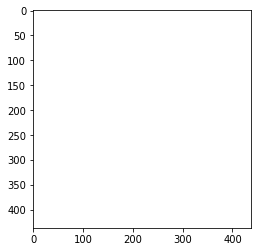

In [13]:

%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt


'''
Parameters
----------
image : ndarray
    Input image data. Will be converted to float.
mode : str
    One of the following strings, selecting the type of noise to add:

    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
'''


import numpy as np
import os
import cv2
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.00001
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    

image = cv2.imread('../../SIGRAPPH2022/clean_image.png') # Only for grayscale image
print(image)
noise_img = noisy("gauss",image)
print(noise_img.shape)
print(noise_img.min())
plt.imshow(noise_img)
#cv2.imshow('sp_noise', noise_img)